# Original Monte Carlo simulation code

# Monte Carlo Simulation

Today, we will work with the Lennard Jones equation.

$$ U(r) = 4 \epsilon \left[\left(\frac{\sigma}{r}\right)^{12} -\left(\frac{\sigma}{r}\right)^{6} \right] $$ 
Reduced units:
$$ U^*\left(r^*_{ij} \right) = 4 \left[\left(\frac{1}{r^*_{ij}}\right)^{12} -\left(\frac{1}{r^*_{ij}}\right)^{6} \right] $$ 

In [2]:
import math, os, random
import matplotlib.pyplot as plt

%matplotlib notebook

def calculate_LJ(r_ij):
    """
    The LJ interaction energy between two particles.
    
    Computes the pairwise Lennard Jones interaction energy based on the separation distance in reduced unites.
    
    Parameters
    ----------
    r_ij : float
        The distance between the particles in reduced units.
        
    Returns
    -------
    pairwise_energy : float
        The pairwise Lennard Jones interaction energy in reduced units.
    
    """
    
    r6_term = math.pow(1/r_ij,6)
    r12_term = math.pow(r6_term,2)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    
    return pairwise_energy

In [3]:
def calculate_distance(coord1,coord2,box_length=None):
    """
    Calculate the distance between two 3D coordinates.
    
    Parameters
    ----------
    coord1, coord2 : list
        The atomic coordinates [x, y, z]
    
    box_length : float, optional
        The box length. This function assumes box is a cube.
    
    Returns
    -------
    distance : float
        The distance between the two atoms.
    """
    distance = 0
    vector = [0,0,0]
    for i in range(3):
        vector[i] = coord1[i] -coord2[i]
        if box_length is None:
            pass
        else:
            if vector[i] > box_length/2:
                vector[i] -= box_length
            elif vector[i] < -box_length/2:
                vector[i] += box_length
        dim_dist = vector[i] ** 2
        
        # if box_length:
        #     
        distance += dim_dist
    distance = math.sqrt(distance)
    return distance

In [4]:
def calculate_total_energy(coordinates, cutoff=3, box_length=None):
    """
    Calculate the total Lennard Jones energy of a system of particles.
    
    Parameters
    ----------
    coordinates : list
        Nested list containing particle coordinates.
        
    cutoff : float
        A criteria distance for intermolecular interaction truncation
    
    box_length : float, optional
        The box length. This function assumes box is a cube.
        
    Returns
    -------
    total_energy : float
        The total pairwise Lennard Jones energy of the system of particles.
    """
    
    total_energy = 0
    
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1,num_atoms):
            
            # print(F'Comparing atom number {i} with atom number {j}')
            
            dist_ij = calculate_distance(coordinates[i], coordinates[j], box_length)
            
            if dist_ij < cutoff:
                interaction_energy = calculate_LJ(dist_ij)
                total_energy += interaction_energy
            
    return total_energy

In [5]:
def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length

# Tail Correction

Truncating interactions using a cutoff removes contribution to the potential energy that might be non-negligible. The tail correction for our system makes a correction for use of the cutoff. We only have to calculate this once at the start of our simulation. The formula is:

$$U_{tail} = \frac{8\pi N^2}{3V} \epsilon \sigma ^3 \left[\frac{1}{3}\left(\frac{\sigma}{r_c}\right)^9 - \left(\frac{\sigma}{r_c}\right)^3\right]$$

In reduced units:

$$U_{tail} = \frac{8\pi N^2}{3V} \left[\frac{1}{3}\left(\frac{1}{r_c}\right)^9 - \left(\frac{1}{r_c}\right)^3\right]$$

In [6]:
def calculate_tail_correction(cutoff, box_length, num_atoms):
    """
    Calculate the tail correction.
    
    Parameters
    ----------
    cutoff : float
        The curoff distance.
        
    box_length : float
        The length of the cell.
       
    num_atoms : int
        Number of atoms in a given system.
       
    Returns
    -------
    tail_co_LJ : float
        A float number that shows the value of tail correction energy for the given system.
    """
    
    tail_co_LJ = 0
    
    coeff = 0
    
    r3 = math.pow(1/cutoff,3)
    r9 = math.pow(r3,3)
    
    coeff = 8 * math.pi * (num_atoms ** 2)/(3 * (box_length ** 3))

    tail_co_LJ = coeff * (r9/3 - r3)
    
    return tail_co_LJ

## Flow of calculations

1. Generate an initial system state 'm'.
2. Choose an atom with uniform probability from state 'm'.
3. Propose a new state 'n' by translating the particle with a uniform random displacement in each direction.
4. Calculate the energy change for the particle.
5. Accept or reject new state.

In [7]:
# Write a for loop
def accept_or_reject(delta_e, beta):
    # beta = 1/temperature
    """
    Accept or reject based on change in energy and temperature.
    """
    
    if delta_e == 0:
        accept = True
    else:
        random_number = random.random()
        p_acc = math.exp(-beta * delta_e)
        
        if random_number < p_acc:
            accept = True
        else:
            accept = False
    return accept

In [8]:
def calculate_pair_energy(coordinates, i_particle, box_length, cutoff):
    """
    Calculate the interaction energy of a particle with its environment (all other particles in the system)
    
    Parameters
    ----------
    coordinates : list
        The coordinates for all particles in the system.
        
    i_particle : int
        The particle index for which to calculate the energy.
        
    box_length : float
        The length of the simulation box
    
    cutoff : float
        The simulation cutoff. Beyond this distance, interactions are not calculated.
        
    Returns
    -------
    e_total : float
        The pairwise interaction energy of the i-th particle with all other particles in the system.
        
    """
    
    e_total = 0
    num_atoms = len(coordinates)
    
    for j_particle in range(num_atoms):
        if j_particle != i_particle:
            dist = calculate_distance(coordinates[j_particle],coordinates[i_particle],box_length)
            if dist <= cutoff:
                e_total += calculate_LJ(dist)
    
    return e_total

In [12]:
# Parameters
reduced_temperature = 1.5
num_steps = 5000
max_displacement = 0.1
cutoff = 3

# Reporting information
freq = 1000
steps = []
energies = []
all_coordinates = []

# Calculated quantities
beta = 1/reduced_temperature

# Read initial coordinates
file_path = os.path.join('lj_sample_configurations','lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
num_particles = len(coordinates)

total_energy = calculate_total_energy(coordinates, cutoff, box_length)
total_energy += calculate_tail_correction(cutoff, box_length, num_particles)

for step in range(num_steps):
    
    # I. Randomly pick one of num_particles particles
    random_particle = random.randrange(num_particles) # This is an integer.
    
    # II. Calculate the interaction energy of the selected particle with the system. Store this value.
    current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # III. Generate a random x, y, z displacement range (-max_displacement, max_displacement) - UNIFORM DISTRIBUTION
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # IV. Notify the coordinate of selected particle by generated displacements.
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # V. Calculate the new interaction energy of moved particles. Store this value.
    proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # VI. Calculate energy change and decide if we accept the move.
    delta_energy = proposed_energy - current_energy
    
    accept = accept_or_reject(delta_energy, beta)
    
    # VII. If accept, keep movement. If not revert to old position.
    if accept:
        total_energy += delta_energy # Extremely important
    else:
        # Move is not accepted. Roll back coordinates.
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # VIII. Print the energy at certain intervals.
    if step % freq == 0:
        print(step, total_energy/num_particles)
        steps.append(step)
        energies.append(total_energy/num_particles)
        all_coordinates.append(coordinates)

0 -5.687310166016909
1000 -5.5875468220146045
2000 -5.507583436047886
3000 -5.464950279669166
4000 -5.397865127901977


<IPython.core.display.Javascript object>


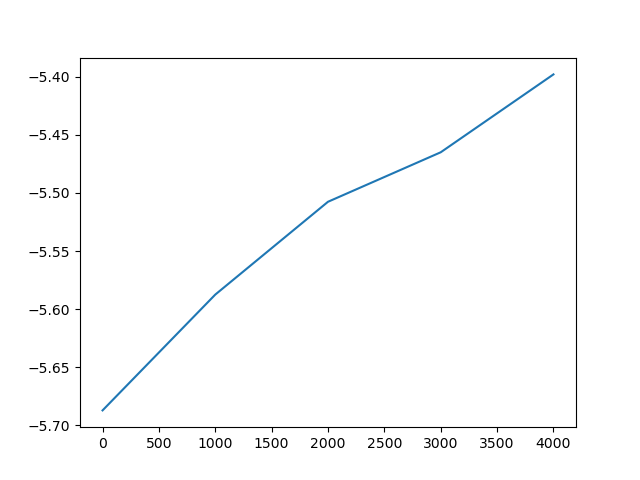

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(steps, energies)

## Exploring the Acceptance Criteria
Calculate the probability of accepting a Monte Carlo move for energies ranging from -2 to 2 for T = 0.9, T = 0.4, and T = 1.4. What is the effect of temperature on the probability of a MC move being accepted? Create a plot showing your results. Note that you aren’t going to be able to use your function accept_or_reject for this. You will have to take p_acc out of it to make the plot.

<IPython.core.display.Javascript object>


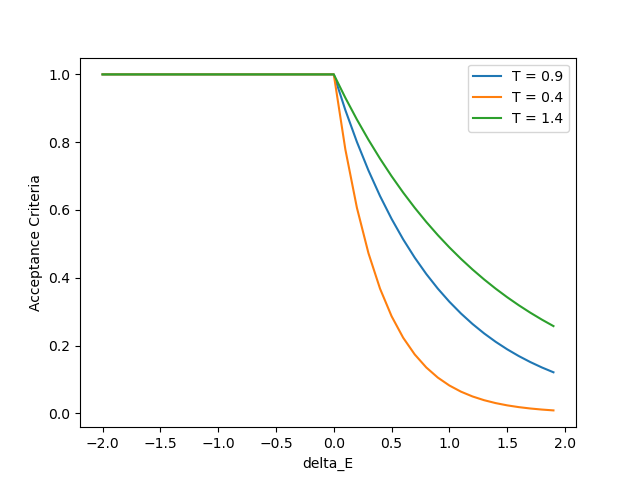

In [24]:
def acceptance_criteria(max_delta_e, temperature):
    """
    Plot the acceptance criteria for a given system ranging within given energy differences.
    
    Parameters
    ----------
    max_delta_e : float
        The maximum delta_e for acceptance criteria calculation
    
    temperature : float
        The parameter of temperature.
        
    """
    beta = 1 / temperature
    delta_es = []
    p_accs = []

    for delta_e in range(-max_delta_e*10,max_delta_e*10):
        delta_e /= 10
        p_acc = math.exp(-beta * delta_e)
        if p_acc > 1:
            p_acc = 1
        delta_es.append(delta_e)
        p_accs.append(p_acc)
    
    ax.plot(delta_es, p_accs, label=F'T = {temperature}')
    plt.legend()
        
        
temperatures = [0.9,0.4,1.4]
fig = plt.figure()
ax = fig.add_subplot(111)
max_delta_e = 2
plt.xlabel('delta_E')
plt.ylabel('Acceptance Criteria')

for temperature in temperatures:
    acceptance_criteria(max_delta_e, temperature)

It can be deduced from the plot that when temperature becomes lower, after delta_e > 0, the acceptance criteria goes faster to zero (i.e. With the same value of positive delta_e, lower temperature holds the property of lower acceptance criteria).

## Radial Distribution Function
Your homework is to calculate the radial distribution function for the final coordinates after 50,000 steps of MC simulation. You should pick another temperature to perform a second simulation and compare the two RDFs. A function for computing the RDF can be provided to you upon request, but it is a bonus if you write your own. You can see some instructions for writing calculating the RDF here. If you prefer to use the provided function, you can find it here.

In [39]:
def rdf(values, max_value, bin_size, num_particles, box_length):
    """
    Calculate the radial distribution function for a set of particles.
    
    Parameters
    ----------
    values : list
        A list of particle particle distances.
    max_value : float
        The maximum value to consider for the calculation.
    bin_size : float
       The interval size, dr, for the radial distribution calculation.
    num_particles : int
        The number of particles in the system
    box_length : float
        The length of the simulation box.
    
    Returns
    -------
    bins : list
        A list of distances
    rdf : list
        A list containing the rdf values for the returned distances.
    """
    
    histogram = []
    bins = []
    num_bins = int(max_value / bin_size)
    
    # Get empty lists to start with
    starting = 0
    for i in range(num_bins):
        histogram.append(0)
        starting += bin_size
        bins.append(starting - bin_size/2)
    
    # First histogram the values
    for value in values:
        if value < max_value:
            hist_index = math.floor(value / bin_size)
            histogram[hist_index] += 1
    
    rdf = []
    # Normalize the values
    for i in range(num_bins):
        normalized = (histogram[i]) / (4 * math.pi * bins[i]**2 * bin_size 
                                       * num_particles ** 2 /(box_length ** 3) )
        rdf.append(normalized)
    
    return bins, rdf

0 -5.687536347860019
1000 -5.681534799143006
2000 -5.722847637233951
3000 -5.71135026485909
4000 -5.695114030996794
5000 -5.703782874480308
6000 -5.679079949535549
7000 -5.6696885358132
8000 -5.629583651069638
9000 -5.651609345532734
10000 -5.648067513401791
11000 -5.657865236048384
12000 -5.66035063628738
13000 -5.632834309153011
14000 -5.607688505437787
15000 -5.59338045714478
16000 -5.6283371982147195
17000 -5.659126943649377
18000 -5.651053173616724
19000 -5.649255152371627
20000 -5.656703179167422
21000 -5.643492147271828
22000 -5.650733944812526
23000 -5.654755690546924
24000 -5.662156818787374
25000 -5.680983002508459
26000 -5.650070653749232
27000 -5.6678760233061505
28000 -5.644958521949163
29000 -5.6430566413624
30000 -5.6511719428317795
31000 -5.668809319675675
32000 -5.655994865745185
33000 -5.64390530895784
34000 -5.668729182959404
35000 -5.66046648391607
36000 -5.64790855870461
37000 -5.646737295154023
38000 -5.625209379102916
39000 -5.6488449133982
40000 -5.6887463766297

<IPython.core.display.Javascript object>


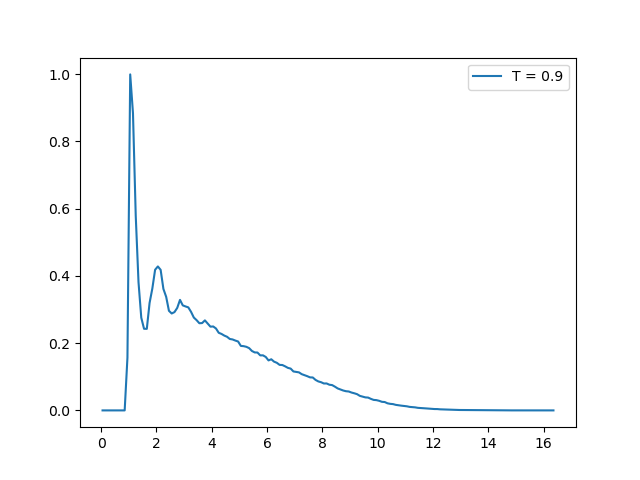

In [38]:
# Parameters
reduced_temperature = 0.9
num_steps = 50000
max_displacement = 0.1
cutoff = 3

# Reporting information
freq = 1000
steps = []
energies = []
distances = []
# all_coordinates = []

# Calculated quantities
beta = 1/reduced_temperature

# Read initial coordinates
file_path = os.path.join('lj_sample_configurations','lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
num_particles = len(coordinates)

total_energy = calculate_total_energy(coordinates, cutoff, box_length)
total_energy += calculate_tail_correction(cutoff, box_length, num_particles)

for step in range(num_steps):
    
    # I. Randomly pick one of num_particles particles
    random_particle = random.randrange(num_particles) # This is an integer.
    
    # II. Calculate the interaction energy of the selected particle with the system. Store this value.
    current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # III. Generate a random x, y, z displacement range (-max_displacement, max_displacement) - UNIFORM DISTRIBUTION
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # IV. Notify the coordinate of selected particle by generated displacements.
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # V. Calculate the new interaction energy of moved particles. Store this value.
    proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # VI. Calculate energy change and decide if we accept the move.
    delta_energy = proposed_energy - current_energy
    
    accept = accept_or_reject(delta_energy, beta)
    
    # VII. If accept, keep movement. If not revert to old position.
    if accept:
        total_energy += delta_energy # Extremely important
    else:
        # Move is not accepted. Roll back coordinates.
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # VIII. Print the energy at certain intervals.
    if step % freq == 0:
        print(step, total_energy/num_particles)
        steps.append(step)
        energies.append(total_energy/num_particles)
        # all_coordinates.append(coordinates)
      
for i in range(num_particles):
    for j in range(i+1,num_particles):
        r_ij = calculate_distance(coordinates[i],coordinates[j])
        distances.append(r_ij)
max_distance = max(distances)
bin_size = 0.1
bins, rdf = rdf(distances, max_distance, bin_size, num_particles, box_length)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(bins, rdf, label=F'T = {reduced_temperature}')
plt.legend()

0 -5.687608511335771
1000 -5.571076673252175
2000 -5.499212767642674
3000 -5.45887065632935
4000 -5.434465023333734
5000 -5.449842303254208
6000 -5.42544180513593
7000 -5.362239163405532
8000 -5.353390145792627
9000 -5.351255467472594
10000 -5.344396930444438
11000 -5.331454627545229
12000 -5.289763483374375
13000 -5.330984813226254
14000 -5.304591056879664
15000 -5.334382062849869
16000 -5.368765842902544
17000 -5.307878573931617
18000 -5.3344587843589
19000 -5.32538969617927
20000 -5.342457465166278
21000 -5.29808042507509
22000 -5.303649542080924
23000 -5.3011531715634455
24000 -5.282156111815684
25000 -5.263925314873561
26000 -5.2813156477546315
27000 -5.259586181148692
28000 -5.289668610278799
29000 -5.276419428530639
30000 -5.250539444491044
31000 -5.250793120425127
32000 -5.263765554219805
33000 -5.288433764618826
34000 -5.262825067220524
35000 -5.213903534122296
36000 -5.262781920748981
37000 -5.256784153578362
38000 -5.228068610141685
39000 -5.204606774239067
40000 -5.21059644

<IPython.core.display.Javascript object>


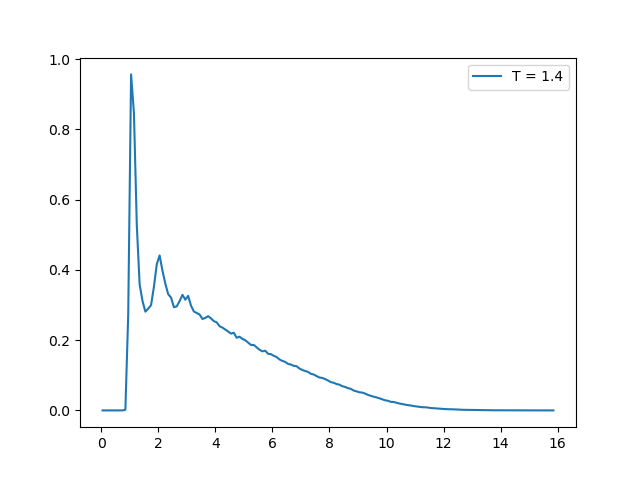

In [40]:
# Parameters
reduced_temperature = 1.4
num_steps = 50000
max_displacement = 0.1
cutoff = 3

# Reporting information
freq = 1000
steps = []
energies = []
distances = []
# all_coordinates = []

# Calculated quantities
beta = 1/reduced_temperature

# Read initial coordinates
file_path = os.path.join('lj_sample_configurations','lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
num_particles = len(coordinates)

total_energy = calculate_total_energy(coordinates, cutoff, box_length)
total_energy += calculate_tail_correction(cutoff, box_length, num_particles)

for step in range(num_steps):
    
    # I. Randomly pick one of num_particles particles
    random_particle = random.randrange(num_particles) # This is an integer.
    
    # II. Calculate the interaction energy of the selected particle with the system. Store this value.
    current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # III. Generate a random x, y, z displacement range (-max_displacement, max_displacement) - UNIFORM DISTRIBUTION
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # IV. Notify the coordinate of selected particle by generated displacements.
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # V. Calculate the new interaction energy of moved particles. Store this value.
    proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # VI. Calculate energy change and decide if we accept the move.
    delta_energy = proposed_energy - current_energy
    
    accept = accept_or_reject(delta_energy, beta)
    
    # VII. If accept, keep movement. If not revert to old position.
    if accept:
        total_energy += delta_energy # Extremely important
    else:
        # Move is not accepted. Roll back coordinates.
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # VIII. Print the energy at certain intervals.
    if step % freq == 0:
        print(step, total_energy/num_particles)
        steps.append(step)
        energies.append(total_energy/num_particles)
        # all_coordinates.append(coordinates)
        
for i in range(num_particles):
    for j in range(i+1,num_particles):
        r_ij = calculate_distance(coordinates[i],coordinates[j])
        distances.append(r_ij)
max_distance = max(distances)
bin_size = 0.1
bins, rdf = rdf(distances, max_distance, bin_size, num_particles, box_length)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(bins, rdf, label=F'T = {reduced_temperature}')
plt.legend()

In two plots, we can see that the first peak is lower when temperature is higher. This means with higher temperature, the spacial distribution of atoms seem more diffuse.